In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import tweepy
import seaborn as sns
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [32]:
api_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.realpath('__file__'))))))
file_name = os.path.join("api_keys.json")
data = json.load(open(file_name))

consumer_key = data['twitter_consumer_key']
consumer_secret = data['twitter_consumer_secret']
access_token = data['twitter_access_token']
access_token_secret = data['twitter_access_token_secret']

In [33]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [34]:
news_labels = {'CNN': 
                   {'name': 'CNN', 
                    'color': 'red'}, 
               'BBCWorld': 
                   {'name': 'BBC World News', 
                    'color': 'blue'}, 
               'CBSNews': 
                   {'name': 'CBS', 
                    'color': 'lightblue'},
               'nytimes': 
                   {'name': 'New York Times', 
                    'color': 'green'}, 
               'FoxNews': 
                   {'name': 'Fox', 
                    'color': 'yellow'}}

In [35]:
news_dict = {
    "Screen Name": [],
    "Tweet": [],
    "Compound Score": [],
    "Positive Score": [],
    "Negative Score": [],
    "Neutral Score": [],
    "Tweets Ago": []
}

In [36]:
for news_org in news_labels.keys():
    tweets_ago = 1 
    for x in range(5): 
        if x == 0:
            response = api.user_timeline(news_org, count = 20) 
        else:
            response = api.user_timeline(news_org, max_id = end_id-1 , count = 20) 
        for tweet in response: 
            text = tweet['text'] 
            date = tweet['created_at'] 
            user = tweet['user']['screen_name'] 
            end_id = tweet['id'] 
            scores = analyzer.polarity_scores(text) 
            news_dict['Screen Name'].append(user) 
            news_dict['Tweet'].append(text)  
            news_dict['Compound Score'].append(scores['compound']) 
            news_dict['Positive Score'].append(scores['pos'])
            news_dict['Negative Score'].append(scores['neg'])
            news_dict['Neutral Score'].append(scores['neu'])
            news_dict['Tweets Ago'].append(tweets_ago)
            tweets_ago +=1 

In [37]:
news_df = pd.DataFrame(news_dict)

In [38]:
len(news_df)

500

In [39]:
news_df.head()

,Compound Score,Negative Score,Neutral Score,Positive Score,Screen Name,Tweet,Tweets Ago
0,0.0000,0.000,1.000,0.0,CNN,This charge demonstrate how taxpayer money can...,1
1,-0.2960,0.155,0.845,0.0,CNN,Cuts to CDC epidemic programs will endanger Am...,2
2,-0.2960,0.167,0.833,0.0,CNN,Here's what you might have missed amid a busy ...,3
3,-0.5106,0.191,0.809,0.0,CNN,"Tablet computers will be given to all 51,000 s...",4
4,0.0000,0.000,1.000,0.0,CNN,Part of Federal Reserve chair Janet Yellen's l...,5


In [40]:
by_org = news_df.groupby('Screen Name')

pos_count = news_df[news_df['Compound Score'] > 0].groupby('Screen Name')['Compound Score'].count()
neg_count = news_df[news_df['Compound Score'] < 0].groupby('Screen Name')['Compound Score'].count()
neu_count = news_df[news_df['Compound Score'] == 0].groupby('Screen Name')['Compound Score'].count()

polarity_df = pd.DataFrame({
    "Positive Compound Scores": pos_count,
    "Negative Compound Scores": neg_count,
    "Neutral Compound Scores": neu_count,
    "Total": pos_count + neg_count + neu_count
})
polarity_df

,Negative Compound Scores,Neutral Compound Scores,Positive Compound Scores,Total
Screen Name,,,,
BBCWorld,44,34,22,100
CBSNews,49,28,23,100
CNN,44,28,28,100
FoxNews,35,39,26,100
nytimes,32,35,33,100


In [41]:
neg_sum = polarity_df['Negative Compound Scores'].sum()
neu_sum = polarity_df['Neutral Compound Scores'].sum()
pos_sum = polarity_df['Positive Compound Scores'].sum()
total = neg_sum + pos_sum + neu_sum

totals_df = pd.DataFrame({
    "Total Negative": [neg_sum],
    "Total Positive": pos_sum,
    "Total Neutral": neg_sum,
    "Total": total
})

totals_df

,Total,Total Negative,Total Neutral,Total Positive
0,500,204,204,132


In [45]:
plt.figure(figsize = (15,10))
plt.xlim(102,-2, -1)
plt.ylim(-1,1)
plt.title('Sentiment Analysis of Media Tweets',
         fontdict = {'fontsize': 20})
for news_org in news_labels.keys():
    df = news_df[news_df['Screen Name'] == news_org]
    yvals = df['Compound Score']
    xvals = df['Tweets Ago']
    labels = news_labels[news_org]['name'] 
    colors = news_labels[news_org]['color'] 
    plt.scatter(xvals,yvals, label = labels, s = 125, color = colors, edgecolor = 'black')
    plt.style.use('seaborn')
    plt.grid()

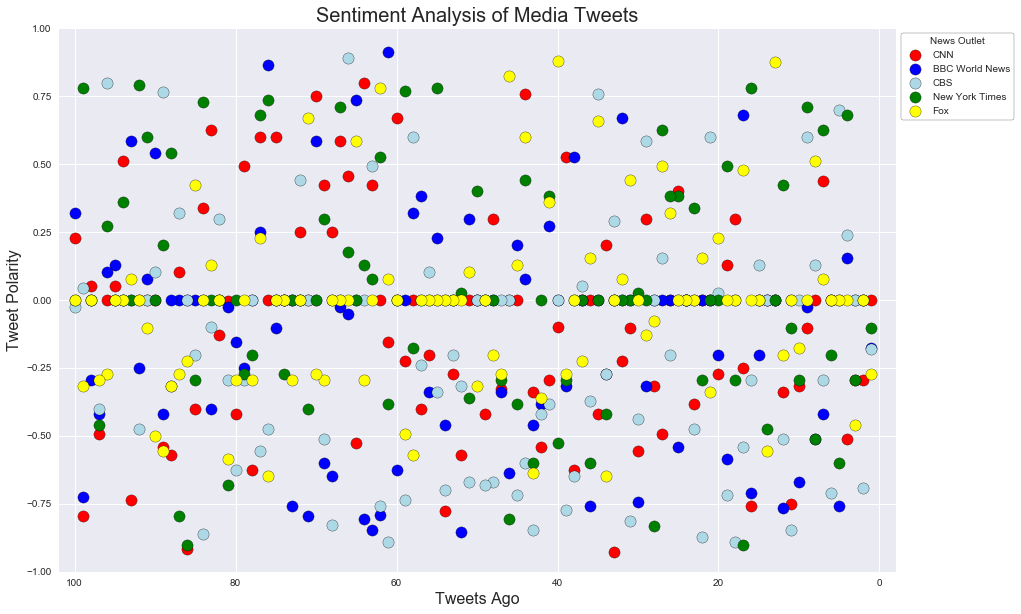

In [46]:
plt.legend(bbox_to_anchor = (1,1),
           frameon = True, 
           edgecolor = 'black', 
           facecolor = 'white',
           title = "News Outlet")
plt.xlabel('Tweets Ago',
          fontdict = {'fontsize': 16})
plt.ylabel('Tweet Polarity',
          fontdict = {'fontsize': 16})
plt.grid()
plt.show()

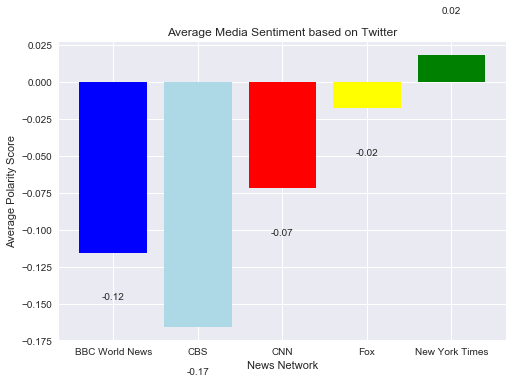

In [47]:
scores_by_org = news_df.groupby('Screen Name')['Compound Score'].mean()


plt.title('Average Media Sentiment based on Twitter')
plt.xlabel('News Network')
plt.ylabel('Average Polarity Score')


xlabels = scores_by_org.index
xvals = np.arange(len(scores_by_org))

count = 0 

for score in scores_by_org: 
    if score < 0: 
        height = score - .03
    else: 
        height = score + .03
    plt.text(count, height, str(round(score, 2)), ha = 'center', va = 'center')
    count += 1
plt.bar(xvals, 
        scores_by_org, 
        color = [news_labels[x]['color'] for x in xlabels], 
        tick_label = [news_labels[x]['name'] for x in xlabels])
plt.style.use('seaborn')
plt.show()